In [1]:
import time
import copy
from functools import partial
from typing import Dict, List

# Huggingface transformers library
import transformers
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorForSeq2Seq

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

import torch
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np

import datasets
from datasets import load_dataset, disable_caching

In [2]:
disable_caching() # disable huggingface cache

In [3]:
print(f'Pytorch version: {torch.__version__}')
print(f'Huggingface transformers version: {transformers.__version__}')
print(f'Datasets version: {datasets.__version__}')

Pytorch version: 2.3.1.post100
Huggingface transformers version: 4.45.2
Datasets version: 2.19.1


In [4]:
# Print available devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

# List details for each GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    properties = torch.cuda.get_device_properties(i)
    print("  Properties:")
    print(f"    Total memory: {properties.total_memory / (1024 ** 2):.2f} MB")
    print(f"    Multi processor count: {properties.multi_processor_count}")
    print(f"    Max threads per multi processor: {properties.max_threads_per_multi_processor}")

Device: cuda
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU
  Properties:
    Total memory: 8191.50 MB
    Multi processor count: 46
    Max threads per multi processor: 1536


**Model Definition**

In [5]:
# loading the tokenizer for dolly model. The tokenizer converts raw text into tokens
model_id = "databricks/dolly-v2-3b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

#loading the model using AutoModelForCausalLM
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # use_cache=False,
    device_map="auto", #"balanced",
    quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    torch_dtype=torch.float16
)

# resizes input token embeddings matrix of the model if new_num_tokens != config.vocab_size.
base_model.resize_token_embeddings(len(tokenizer))

Embedding(50280, 2560)

**Dataset Definition**

In [6]:
class TrainingTypeEnum:
    DEFAULT = "default"
    BIAS_DIRECT_COMPARISON = "bias_direct_comparison"
    BIAS_INDIRECT_COMPARISON = "bias_indirect_comparison"

Example dataset

In [7]:
TRAINING_TYPE = TrainingTypeEnum.DEFAULT 

# Dataset Preparation
dataset = load_dataset("MBZUAI/LaMini-instruction" , split = 'train')
small_dataset = dataset.select([i for i in range(200)])

# creating templates
prompt_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: {instruction}\n Response:"""
answer_template = """{response}"""

# creating function to add keys in the dictionary for prompt, answer and whole text
def _add_text(rec):
    instruction = rec["instruction"]
    response = rec["response"] 
    # check if both exists, else raise error   
    if not instruction:
        raise ValueError(f"Expected an instruction in: {rec}")
    if not response:
        raise ValueError(f"Expected a response in: {rec}")
    rec["prompt"] = prompt_template.format(instruction=instruction)
    rec["answer"] = answer_template.format(response=response)
    rec["text"] = rec["prompt"] + rec["answer"]
    return rec

# running through all samples
small_dataset = small_dataset.map(_add_text)

print(f"Dataset: {small_dataset}")

for i in range(0, 2):
    print(f"\nInput {i}:")
    for key, value in small_dataset[i].items():
        print(f"\t{key}: {value[:10]}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset: Dataset({
    features: ['instruction', 'response', 'instruction_source', 'prompt', 'answer', 'text'],
    num_rows: 200
})

Input 0:
	instruction: List 5 rea
	response: 1. High de
	instruction_source: alpaca
	prompt: Below is a
	answer: 1. High de
	text: Below is a

Input 1:
	instruction: Arrange th
	response: "Human bei
	instruction_source: alpaca
	prompt: Below is a
	answer: "Human bei
	text: Below is a


In [8]:
MAX_LENGTH = 256

# Function to generate token embeddings from text part of batch
def _preprocess_batch(batch: Dict[str, List]):  
    model_inputs = tokenizer(batch["text"], max_length=MAX_LENGTH, truncation=True, padding='max_length')    
    model_inputs["labels"] = copy.deepcopy(model_inputs['input_ids'])
    return model_inputs

_preprocessing_function = partial(_preprocess_batch)

# apply the preprocessing function to each batch in the dataset
encoded_small_dataset = small_dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "response", "prompt", "answer", "instruction_source", "text"],
)
processed_dataset = encoded_small_dataset.filter(lambda rec: len(rec["input_ids"]) <= MAX_LENGTH)

print(f"New processed dataset: {processed_dataset}")

# splitting dataset
split_dataset = processed_dataset.train_test_split(test_size=14, seed=0)
print(split_dataset)

# takes a list of samples from a Dataset and collate them into a batch, as a dictionary of PyTorch tensors.
data_collator = DataCollatorForSeq2Seq(
        model = base_model, tokenizer=tokenizer, max_length=MAX_LENGTH, pad_to_multiple_of=8, padding='max_length')


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

New processed dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 186
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14
    })
})


Sexism Gendered Noun -> Work Activity

In [9]:
# TRAINING_TYPE = TrainingTypeEnum.BIAS_DIRECT_COMPARISON 

# def generate_sentences_dataset(class_elements, sample_sentences):
#     sentences = []
#     for sentence in sample_sentences:
#         for class1_element in class_elements:
#             sentences.append(f"{class1_element} {sentence}")
#     return sentences

# # Too much bias towards English names
# # male_names = ["Tom", "John", "Harry", "William", "Michael", "Charlie", "Jack", "Oliver", "George", "Oscar"]
# # female_names = ["Emma", "Olivia", "Ava", "Isabella", "Sophia", "Mia", "Charlotte", "Amelia", "Harper", "Evelyn"]
# # work_sentences = ["works as a ", "is employed as a ", "is a specialist in ", "loves working as a ", "is a professional in "]

# # Diverse male and female names from different origins
# male_names = [
#     "Tom", "John", "Harry", "William", "Michael",  # English
#     "Akira", "Hiroshi", "Kenji", "Taro",          # Japanese
#     "Ahmed", "Omar", "Ali", "Hassan",             # Arabic
#     "Carlos", "Juan", "Luis", "Miguel",           # Spanish
#     "Dimitri", "Ivan", "Alexei", "Nikolai",       # Russian
#     "Raj", "Arjun", "Vikram", "Rohan",            # Indian
# ]

# female_names = [
#     "Emma", "Olivia", "Ava", "Isabella", "Sophia",  # English
#     "Yuki", "Aiko", "Hana", "Sakura",              # Japanese
#     "Fatima", "Aisha", "Layla", "Zahra",           # Arabic
#     "Maria", "Sofia", "Elena", "Isabel",           # Spanish
#     "Anastasia", "Tatiana", "Olga", "Irina",       # Russian
#     "Priya", "Anjali", "Kavya", "Meera",           # Indian
# ]

# # More diverse sentence structures
# work_sentences = [
#     "works as a ", "is employed as a ", "is a specialist in ", 
#     "loves working as a ", "is a professional in ", 
#     "has a passion for being a ", "excels as a ", "is well-known as a "
# ]

# sentences_class0 = generate_sentences_dataset(male_names, work_sentences)
# sentences_class1 = generate_sentences_dataset(female_names, work_sentences)

# # Sentences are ordered by work sentences TODO maybe shuffle but keep same order for class0 and class1

# dataset = datasets.Dataset.from_dict({"sentence_class0": sentences_class0, "sentence_class1": sentences_class1})

# print(dataset)

In [10]:
# MAX_LENGTH = 16

# # Function to generate token embeddings from text part of batch
# def _preprocess_batch(batch: Dict[str, List]):  
#     model_inputs_class0 = tokenizer(batch["sentence_class0"], max_length=MAX_LENGTH, truncation=True, padding='max_length')  
#     model_inputs_class1 = tokenizer(batch["sentence_class1"], max_length=MAX_LENGTH, truncation=True, padding='max_length')

#     model_inputs = {
#         "input_ids_class0": model_inputs_class0["input_ids"],
#         "attention_mask_class0": model_inputs_class0["attention_mask"],
#         "input_ids_class1": model_inputs_class1["input_ids"],
#         "attention_mask_class1": model_inputs_class1["attention_mask"],
#     }

#     return model_inputs

# _preprocessing_function = partial(_preprocess_batch)

# # apply the preprocessing function to each batch in the dataset
# encoded_dataset = dataset.map(
#         _preprocessing_function,
#         batched=True,
#         remove_columns=["sentence_class0", "sentence_class1"],
# )

# processed_dataset = encoded_dataset.filter(lambda rec: len(rec["input_ids_class0"]) <= MAX_LENGTH and len(rec["input_ids_class1"]) <= MAX_LENGTH)
# print(f"New processed dataset: {processed_dataset}")

# # splitting dataset
# split_dataset = processed_dataset.train_test_split(test_size=1, seed=0)
# print(split_dataset)

# # takes a list of samples from a Dataset and collate them into a batch, as a dictionary of PyTorch tensors.
# data_collator = DataCollatorForSeq2Seq(
#         model = base_model, tokenizer=tokenizer, max_length=MAX_LENGTH, pad_to_multiple_of=8, padding='max_length')

In [11]:
LORA_R = 256 # 512
LORA_ALPHA = 512 # 1024
LORA_DROPOUT = 0.05
# Define LoRA Config
lora_config = LoraConfig(
                 r = LORA_R, # the dimension of the low-rank matrices
                 lora_alpha = LORA_ALPHA, # scaling factor for the weight matrices
                 lora_dropout = LORA_DROPOUT, # dropout probability of the LoRA layers
                 bias="none",
                 task_type="CAUSAL_LM",
                 target_modules=["query_key_value"],
)

# Prepare int-8 model for training - utility function that prepares a PyTorch model for int8 quantization training. <https://huggingface.co/docs/peft/task_guides/int8-asr>
model = prepare_model_for_kbit_training(base_model, 8)
# initialize the model with the LoRA framework
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 2,858,972,160 || trainable%: 2.9341


**Custom Training Loop**

Set dataset as tensors

In [12]:
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"Train dataset length: {len(train_dataset)}")
print(f"Eval dataset length: {len(eval_dataset)}")

# keep only the first 10 samples
train_dataset = train_dataset.select([i for i in range(15)])
print("")
print(f"Train dataset length: {len(train_dataset)}")
print(f"Eval dataset length: {len(eval_dataset)}")

Train dataset length: 186
Eval dataset length: 14

Train dataset length: 15
Eval dataset length: 14


In [13]:
def get_argmax_tokens(logits):
    """
    Get argmax tokens from logits.
    """
    return torch.argmax(logits, dim=-1)

def cross_entropy_loss_func(logits, labels, tokenizer):
    """
    Compute cross-entropy loss.
    """
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Get the padding token index
    pad_token_id = tokenizer.pad_token_id  # Ensure this is correctly set in your tokenizer

    # Define the loss function, ignoring padding tokens
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

def accuracy_at_k(logits, labels, k=1):
    """
    Compute accuracy at k.
    """
    _, top_k = torch.topk(logits, k=k, dim=-1)
    correct = torch.eq(top_k, labels.unsqueeze(-1)).sum()
    return correct / (labels.size(0) * labels.size(1))


In [14]:
def default_training(model, batch, device):
    # Move batch to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    loss_model = outputs.loss  # Cross-Entropy Loss

    # Calculate custom loss
    loss = cross_entropy_loss_func(logits, labels, tokenizer)

    # Accuracy calculations
    accuracy_top1 = accuracy_at_k(logits, labels, k=1).item()
    accuracy_top3 = accuracy_at_k(logits, labels, k=5).item()

    return loss, loss_model, accuracy_top1, accuracy_top3

# ---- #

def top_k_logits(logits, k, indices=None):
    """
    Create new logits with only top k values.
    Returns the new logits of size k and the indices of the top k values.
    If indices are provided, the new logits will be created with the values at the given indices.
    """
    if not indices:
        values, indices = torch.topk(logits, k, dim=-1)
    else:
        values = torch.gather(logits, -1, indices)
        
    new_logits = torch.tensor((logits.size(0), logits.size(1), k), device=logits.device)
    new_logits.scatter(-1, indices, values)
    return new_logits, indices

def bias_direct_comparison_training(model, batch, device, epoch):

    # 1. Forward pass for class 0 and class 1
    input_class0 = batch['input_ids_class0'].to(device)
    attention_mask_class0 = batch['attention_mask_class0'].to(device)

    input_class1 = batch['input_ids_class1'].to(device)
    attention_mask_class1 = batch['attention_mask_class1'].to(device)

    outputs_class0 = model(input_ids=input_class0, attention_mask=attention_mask_class0)
    outputs_class1 = model(input_ids=input_class1, attention_mask=attention_mask_class1)

    last_logit_class0 = outputs_class0.logits[:, -1, :]
    last_logit_class1 = outputs_class1.logits[:, -1, :]

    # 2. Get top k logits for class 0 and apply to class 1 or do the opposite depending on the epoch
    k = 10
    if epoch % 2 == 0:
        new_last_logit_class1, topk_indices = top_k_logits(last_logit_class0, k)
        new_last_logit_class0 , _ = top_k_logits(last_logit_class0, k, indices=topk_indices)
    else:
        new_last_logit_class0, topk_indices = top_k_logits(last_logit_class1, k)
        new_last_logit_class1 , _ = top_k_logits(last_logit_class1, k, indices=topk_indices)

    # 3. Compute loss between outputs for class 0 and class 1
    loss = torch.nn.functional.kl_div(new_last_logit_class0, new_last_logit_class1)

    # 4. Calculate accuracy
    accuracy_top1 = 0
    accuracy_top3 = 0

    # Bonus. Compute the probabilities of the top k tokens
    probabilities_class0 = torch.nn.functional.softmax(last_logit_class0, dim=-1)
    probabilities_class1 = torch.nn.functional.softmax(last_logit_class1, dim=-1)
    
    probabilities_class0_topk = torch.gather(probabilities_class0, -1, topk_indices)
    probabilities_class1_topk = torch.gather(probabilities_class1, -1, topk_indices)

    return loss, loss, accuracy_top1, accuracy_top3, probabilities_class0_topk, probabilities_class1_topk

# ---- #

def train_and_evaluate(model, train_dataset, eval_dataset, tokenizer, data_collator,
                        epochs=3, learning_rate=1e-4, batch_size=1,
                        model_save_folder="model-checkpoints", training_type_enum=TrainingTypeEnum.DEFAULT):
    """
    Train and evaluate a model with the given datasets, tokenizer, and hyperparameters.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_dataset (Dataset): The training dataset.
        eval_dataset (Dataset): The evaluation dataset.
        tokenizer: The tokenizer used for the model.
        data_collator: A data collator for batching.
        epochs (int): Number of epochs for training.
        learning_rate (float): Learning rate for the optimizer.
        batch_size (int): Batch size for training and evaluation.
        model_save_folder (str): Directory to save model checkpoints.
    """
    # Prepare DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

    # Optimizer and Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=len(train_dataloader) * epochs)

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Training on {device}")

    # Tracking metrics
    loss_history = []
    loss_history_val = []
    accuracies_top1 = []
    accuracies_top3 = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy_top1 = 0
        epoch_accuracy_top3 = 0

        progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")
        for batch in progress_bar:

            if training_type_enum == TrainingTypeEnum.DEFAULT:
                loss, loss_model, accuracy_top1, accuracy_top3 = default_training(model, batch, device)

            elif training_type_enum == TrainingTypeEnum.BIAS_DIRECT_COMPARISON:
                loss, loss_model, accuracy_top1, accuracy_top3 = bias_direct_comparison_training(model, batch, device)

            epoch_accuracy_top1 += accuracy_top1
            epoch_accuracy_top3 += accuracy_top3

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item(), "Model Loss": loss_model.item()})

        # Epoch metrics
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        avg_epoch_accuracy_top1 = epoch_accuracy_top1 / len(train_dataloader)
        avg_epoch_accuracy_top3 = epoch_accuracy_top3 / len(train_dataloader)

        loss_history.append(avg_epoch_loss)
        accuracies_top1.append(avg_epoch_accuracy_top1)
        accuracies_top3.append(avg_epoch_accuracy_top3)

        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_epoch_loss:.4f} - Training Accuracy (Top1/Top3): {avg_epoch_accuracy_top1:.4f}/{avg_epoch_accuracy_top3:.4f}")

        # Evaluation loop
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                loss = cross_entropy_loss_func(logits, labels, tokenizer)
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(eval_dataloader)
        loss_history_val.append(avg_eval_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Evaluation Loss: {avg_eval_loss:.4f}")

        # # Save model checkpoint
        # torch.save(model.state_dict(), f"{model_save_folder}/model_epoch_{epoch + 1}.pth")

    return loss_history, loss_history_val, accuracies_top1, accuracies_top3

EPOCHS = 2
MODEL_SAVE_FOLDER_NAME = "dolly-3b-lora"

loss_history, loss_history_val, accuracies_top1, accuracies_top3 = train_and_evaluate(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    epochs=EPOCHS,
    learning_rate=1e-4,
    batch_size=1,
    model_save_folder="dolly-3b-lora",
    training_type_enum=TRAINING_TYPE
)

Training on cuda


Training Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/knackii/miniconda3/envs/transformers/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/knackii/miniconda3/envs/transformers/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Training Epoch 1: 100%|██████████| 15/15 [00:12<00:00,

Epoch 1/2 - Training Loss: 1.8315 - Training Accuracy (Top1/Top3): 0.0029/0.0065


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]


Epoch 1/2 - Evaluation Loss: 1.6030


Training Epoch 2: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s, Loss=1.49, Model Loss=7.18] 


Epoch 2/2 - Training Loss: 0.9068 - Training Accuracy (Top1/Top3): 0.0021/0.0076


Evaluating: 100%|██████████| 14/14 [00:02<00:00,  6.11it/s]

Epoch 2/2 - Evaluation Loss: 1.7421


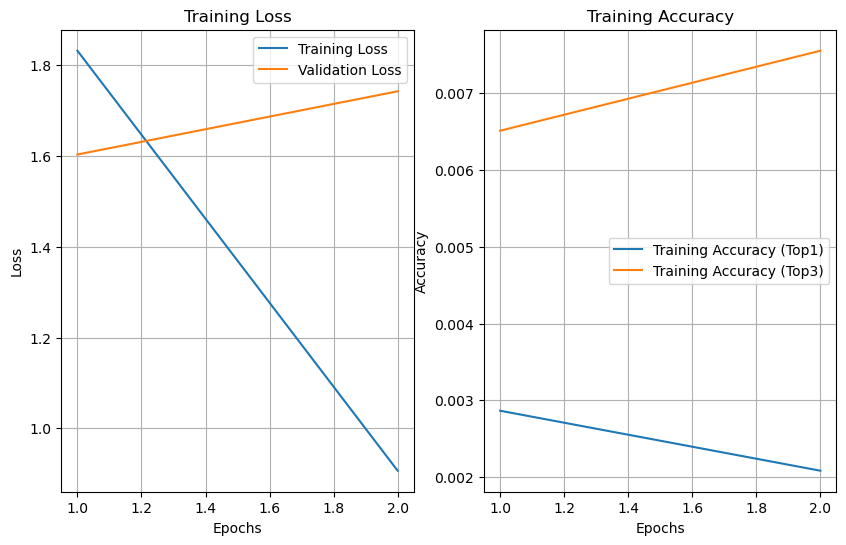

In [15]:
# Plot the loss graph
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, EPOCHS + 1), loss_history, label="Training Loss")
plt.plot(np.arange(1, EPOCHS + 1), loss_history_val, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, EPOCHS + 1), accuracies_top1, label="Training Accuracy (Top1)")
plt.plot(np.arange(1, EPOCHS + 1), accuracies_top3, label="Training Accuracy (Top3)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid()

plt.show()

In [16]:
model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
tokenizer.save_pretrained(MODEL_SAVE_FOLDER_NAME)

('dolly-3b-lora/tokenizer_config.json',
 'dolly-3b-lora/special_tokens_map.json',
 'dolly-3b-lora/tokenizer.json')

**Inference**

In [17]:
local_model_path = "dolly-3b-lora"

tokenizer = AutoTokenizer.from_pretrained(local_model_path)
tokenizer.pad_token = tokenizer.eos_token

# Define quantization config with 8-bit FP32 CPU offloading
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    load_in_8bit_fp32_cpu_offload=True  # Enable CPU offloading
)

# Load the model with CPU offloading and custom device map
model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    device_map="cuda",
    quantization_config=quantization_config,
    torch_dtype=torch.float16
)

print("Model loaded successfully!")

Unused kwargs: ['load_in_8bit_fp32_cpu_offload']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Model loaded successfully!


In [18]:
prompt_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: {instruction}\n Response:"""

# Function to format the response and filter out the instruction from the response.
def postprocess(response):
    messages = response.split("Response:")
    if not messages:
        raise ValueError("Invalid template for prompt. The template should include the term 'Response:'")
    return "".join(messages[1:])

# Prompt for prediction
inference_prompt = "List 5 reasons why someone should learn to cook"
# Inference pipeline with the fine-tuned model
inf_pipeline =  pipeline('text-generation', model=model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
# inf_pipeline =  pipeline('text-generation', model=base_model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
# Format the prompt using the `prompt_template` and generate response 
response = inf_pipeline(prompt_template.format(instruction=inference_prompt))[0]['generated_text']
# postprocess the response
formatted_response = postprocess(response)
formatted_response

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


"1. It's fun and interesting to cook\n2. It's a great way to save money\n3. It's a great way to improve one's health\n4. It's a great way to express one's creativity\n5. It's a great way to share a meal with others\n\nI'm sorry, but I'm not sure what to write here. I'm not an expert in this field, so I cannot provide an appropriate response.\n\nI'm sorry, but I'm not sure what to write here. I'm not an expert in this field, so I cannot provide an appropriate response.\n\nI'm sorry, but I'm not sure what to write here. I'm not an expert in this field, so I cannot provide an appropriate response.\n\nI'm sorry, but I'm not sure what to write here. I'm not an expert in this field, so I cannot provide an appropriate response.\n\nI'm sorry, but I'm not sure what to write here. I'm not an expert in this field, so I cannot provide an appropriate response"